In [434]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost as xgb

In [435]:
train = pd.read_csv('../input/application_train.csv')
test = pd.read_csv('../input/application_test.csv')

In [436]:
train.shape, test.shape

((307511, 122), (48744, 121))

In [437]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [438]:
missing_values_table(train).head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [439]:
missing_values_table(test).head(20)

Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [440]:
# Check if the target has any nan value
train['TARGET'].isna().sum()

0

<AxesSubplot:ylabel='Frequency'>

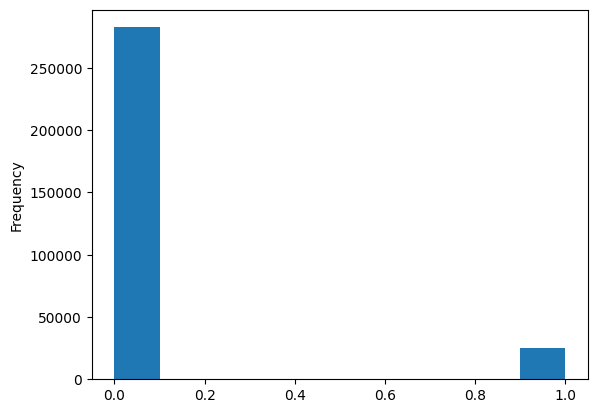

In [441]:
# 1 and 0 distribution
train['TARGET'].astype(int).plot.hist()

In [442]:
set(train.columns).difference(test.columns)

{'TARGET'}

In [443]:
set(test.columns).difference(train.columns)

set()

In [444]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [445]:
test.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

In [446]:
# Number of unique classes in each object column
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [447]:
# Number of unique classes in each object column
test.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [448]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [449]:
# before one hot encoding
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 122)
Testing shape:  (48744, 121)


In [450]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 243)
Testing shape:  (48744, 239)


In [451]:
# Alligning data

# Get train
train_labels = train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['TARGET'] = train_labels

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 240)
Testing shape:  (48744, 239)


In [452]:
train.dtypes.value_counts()

uint8      131
float64     65
int64       41
int32        3
dtype: int64

In [453]:
test.dtypes.value_counts()

uint8      131
float64     65
int64       40
int32        3
dtype: int64

# Start doing the EDA

In [454]:
missing_values_table(train).head()

Your selected dataframe has 240 columns.
There are 61 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,214865,69.9
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4


In [455]:
missing_values_table(test).head()

Your selected dataframe has 239 columns.
There are 58 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
NONLIVINGAPARTMENTS_MODE,33347,68.4
NONLIVINGAPARTMENTS_MEDI,33347,68.4


In [456]:
train.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.095213,0.340108,0.693673,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,...,0.030090,0.007466,0.005785,0.005284,0.214757,0.210773,0.017437,0.518446,0.007570,0.080729
std,102790.175348,0.293509,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,...,0.170835,0.086085,0.075840,0.072501,0.410654,0.407858,0.130892,0.499660,0.086679,0.272419
min,100002.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,456255.000000,1.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [457]:
test.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
count,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,...,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000
mean,277796.676350,0.009006,0.337129,0.690505,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,...,0.004185,0.029296,0.007242,0.005929,0.005826,0.231187,0.214057,0.016289,0.537071,0.007303
std,103169.547296,0.094474,0.472734,0.462290,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,...,0.064558,0.168636,0.084792,0.076772,0.076109,0.421596,0.410171,0.126587,0.498629,0.085149
min,100001.000000,0.000000,0.000000,0.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,0.000000,1.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,367555.500000,0.000000,1.000000,1.000000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,456250.000000,1.000000,1.000000,1.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [458]:
corr = train.corr()

In [459]:
corr['TARGET'].sort_values(ascending=False).head(15)

TARGET                                               1.000000
DAYS_BIRTH                                           0.078239
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_DOCUMENT_3                                      0.044346
OCCUPATION_TYPE_Laborers                             0.043019
DAYS_REGISTRATION                                    0.041975
Name: TARGET, dtype: float64

In [460]:
corr['TARGET'].sort_values(ascending=False).tail(15)

REGION_POPULATION_RELATIVE             -0.037227
AMT_GOODS_PRICE                        -0.039645
HOUSETYPE_MODE_block of flats          -0.040594
EMERGENCYSTATE_MODE_No                 -0.042201
FLOORSMAX_MODE                         -0.043226
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_AVG                          -0.044003
DAYS_EMPLOYED                          -0.044932
ORGANIZATION_TYPE_XNA                  -0.045987
NAME_INCOME_TYPE_Pensioner             -0.046209
CODE_GENDER_F                          -0.054704
NAME_EDUCATION_TYPE_Higher education   -0.056593
EXT_SOURCE_1                           -0.155317
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_3                           -0.178919
Name: TARGET, dtype: float64

<AxesSubplot:title={'center':'Days Birth'}>

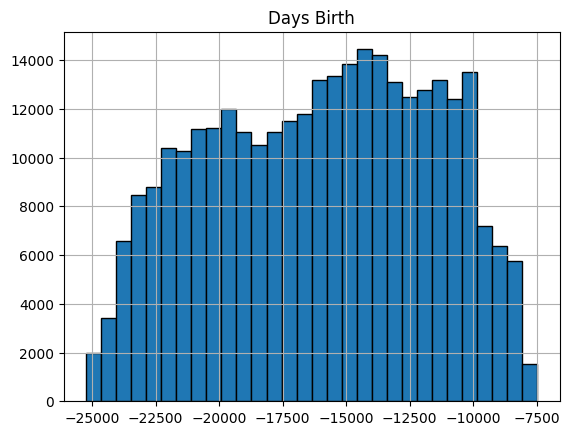

In [461]:
# That's weird
plt.title("Days Birth")
train["DAYS_BIRTH"].hist(edgecolor='black', bins=30)

<AxesSubplot:title={'center':'Days Birth'}>

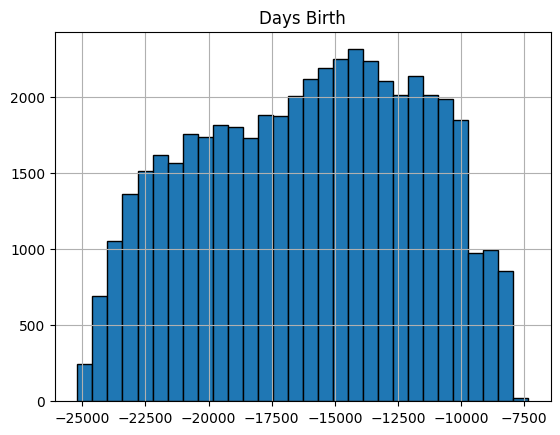

In [462]:
# That's weird
plt.title("Days Birth")
test["DAYS_BIRTH"].hist(edgecolor='black', bins=30)

In [463]:
train["DAYS_BIRTH"] = train['DAYS_BIRTH'] / -365
test["DAYS_BIRTH"] = test['DAYS_BIRTH'] / -365

<AxesSubplot:title={'center':'Days Employed'}>

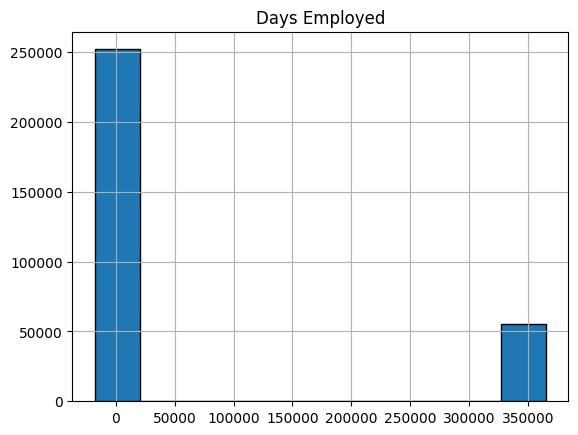

In [464]:
# That's weird
plt.title("Days Employed")
train["DAYS_EMPLOYED"].hist(edgecolor='black')

<AxesSubplot:title={'center':'Days Employed'}>

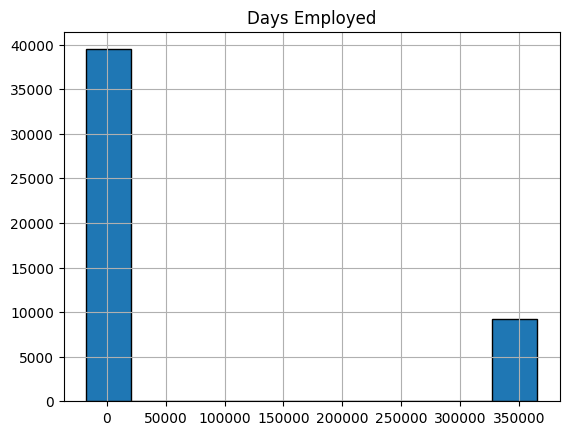

In [465]:
# That's weird
plt.title("Days Employed")
test["DAYS_EMPLOYED"].hist(edgecolor='black')

In [466]:
train["DAYS_EMPLOYED"].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [467]:
percentage = train[train["DAYS_EMPLOYED"]==365243].shape[0]/len(train)*100
print("Percentage of rows that have days employed == 365243 is...", percentage, "%")
print("Notice that 365243 days is", 365243/365, "years")

Percentage of rows that have days employed == 365243 is... 18.00716071945394 %
Notice that 365243 days is 1000.6657534246575 years


In [468]:
# Make it into nan
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace(365243, np.nan)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].replace(365243, np.nan)

<AxesSubplot:title={'center':'Days Employed'}>

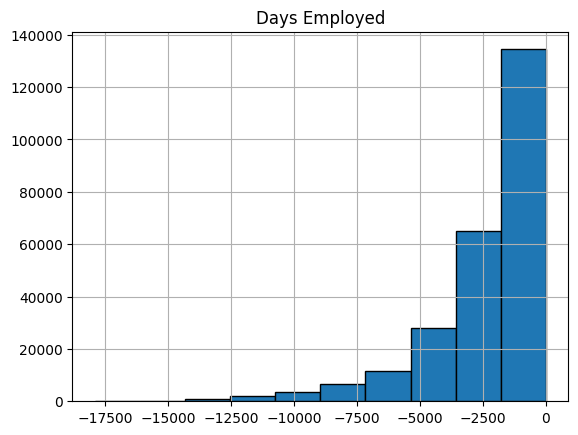

In [469]:
# That's weird
plt.title("Days Employed")
train["DAYS_EMPLOYED"].hist(edgecolor='black', bins=10)

In [470]:
train["DAYS_EMPLOYED"] = train['DAYS_EMPLOYED'] / -365
test["DAYS_EMPLOYED"] = test['DAYS_EMPLOYED'] / -365

In [471]:
temp = train[train['DAYS_EMPLOYED'].isna()]
temp.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
8,100011,0,0,1,0,112500.000,1019610.0,33826.5,913500.0,0.018634,...,0,0,0,0,0,0,0,0,0,0
11,100015,0,0,1,0,38419.155,148365.0,10678.5,135000.0,0.015221,...,0,0,0,0,0,0,0,0,0,0
23,100027,0,0,1,0,83250.000,239850.0,23850.0,225000.0,0.006296,...,0,1,0,0,0,0,0,1,0,0
38,100045,0,0,1,0,99000.000,247275.0,17338.5,225000.0,0.006207,...,0,0,0,0,0,1,0,1,0,0
43,100050,0,0,1,0,108000.000,746280.0,42970.5,675000.0,0.010966,...,0,0,0,0,1,0,0,1,0,0


<AxesSubplot:title={'center':'Target on troublesome DAYS_EMPLOYED rows'}>

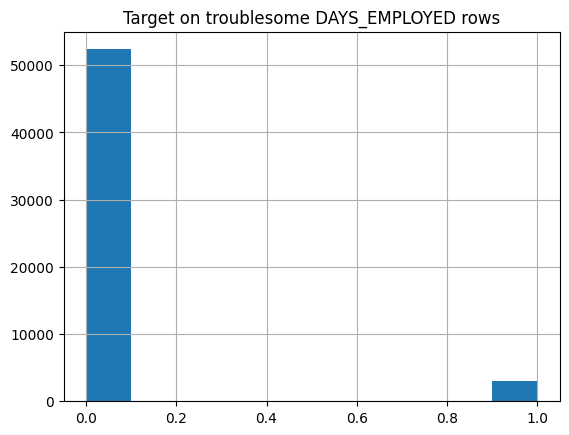

In [472]:
plt.title("Target on troublesome DAYS_EMPLOYED rows")
temp["TARGET"].hist()

In [473]:
temp.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
count,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,5.537400e+04,5.537400e+04,55374.000000,5.535200e+04,55374.000000,...,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000
mean,278480.472424,0.060787,0.183642,0.762632,0.046123,1.363956e+05,5.426899e+05,23904.303202,4.882973e+05,0.020749,...,0.031459,0.006790,0.004659,0.004804,0.211309,0.205457,0.016614,0.507224,0.006899,0.053996
std,102674.560705,0.238941,0.387196,0.425473,0.275873,7.666086e+04,3.784991e+05,13308.379238,3.471510e+05,0.013635,...,0.174556,0.082123,0.068100,0.069143,0.408240,0.404039,0.127822,0.499952,0.082771,0.226013
min,100011.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.500000e+04,0.000290,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189622.250000,0.000000,0.000000,1.000000,0.000000,9.000000e+04,2.547000e+05,14503.500000,2.250000e+05,0.010032,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,279001.500000,0.000000,0.000000,1.000000,0.000000,1.170000e+05,4.578345e+05,21775.500000,4.500000e+05,0.018850,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,367053.000000,0.000000,0.000000,1.000000,0.000000,1.665000e+05,7.551900e+05,29943.000000,6.750000e+05,0.026392,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,456252.000000,1.000000,1.000000,1.000000,14.000000,2.250000e+06,3.312162e+06,225000.000000,3.150000e+06,0.072508,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [474]:
test["DAYS_EMPLOYED"].isna().sum()

9274

In [475]:
# Assuming 'train' is your dataset
column_to_impute = "DAYS_EMPLOYED"

imptr = IterativeImputer(estimator=xgb.XGBRegressor(n_estimators=1000,
                                                    random_state=42,
                                                    tree_method='gpu_hist',
                                                    ),
                         missing_values=np.nan,
                         max_iter=10,
                         initial_strategy='mean',
                         imputation_order='ascending',
                         verbose=2,
                         random_state=42,
                         n_nearest_features=5
                         )

train[column_to_impute] = imptr.fit_transform(train[column_to_impute].values.reshape(-1, 1))
test[column_to_impute] = imptr.transform(test[column_to_impute].values.reshape(-1, 1))

<AxesSubplot:title={'center':'Days Employed'}>

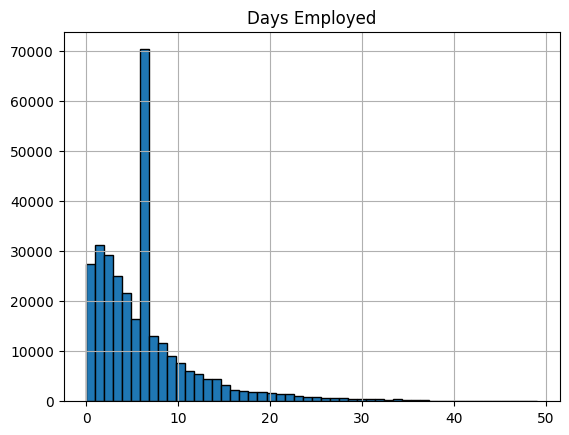

In [476]:
# That's weird
plt.title("Days Employed")
train["DAYS_EMPLOYED"].hist(edgecolor='black', bins=50)

<AxesSubplot:title={'center':'Days Employed'}>

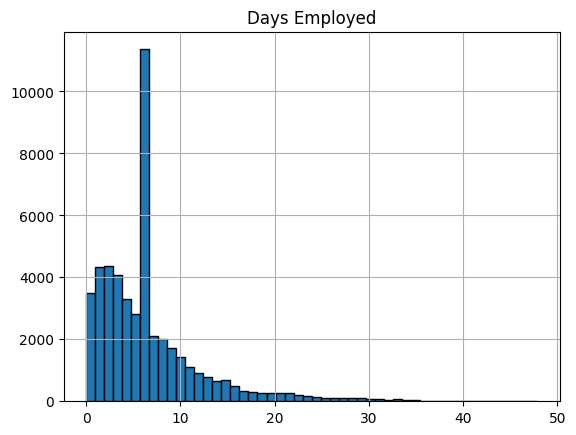

In [477]:
# That's weird
plt.title("Days Employed")
test["DAYS_EMPLOYED"].hist(edgecolor='black', bins=50)

In [478]:
train["DAYS_EMPLOYED"].value_counts()

6.531971     55374
0.547945       156
0.613699       152
0.630137       151
0.545205       151
             ...  
38.249315        1
32.402740        1
27.879452        1
25.915068        1
23.819178        1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

In [479]:
test["DAYS_EMPLOYED"].value_counts()

6.531971     9274
3.065753       32
1.065753       31
3.397260       30
0.405479       28
             ... 
24.668493       1
9.473973        1
22.186301       1
18.041096       1
17.947945       1
Name: DAYS_EMPLOYED, Length: 7863, dtype: int64